# Predicting hospital admission at emergency department triage using machine learning.
## Prediction Evaluation with:  MLPClassifier(DNN)

MLPClassifier is a strong choice for predicting hospital admissions at emergency department triage due to its ability to model complex, non-linear relationships in the data. It leverages neural networks, which are highly flexible and can capture intricate patterns that simpler models might miss. MLPClassifier also supports extensive hyperparameter tuning, allowing for optimization to achieve high accuracy. Additionally, it can handle both numerical and categorical data effectively when combined with appropriate preprocessing steps. MLPClassifier is robust and scalable, making it suitable for handling large datasets and ensuring reliable predictions in critical healthcare environments.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
import pickle
import datetime
import seaborn as sns

In [2]:
import pandas as pd
# Load  dataset
data = pd.read_csv('./admission.csv')

# Train and evaluate the model with a specified number of components=200 for SVD

Start Time: 2024-10-27 11:04:51.998501


/home/faruque/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['phencyclidine(pcp)screen,urine,noconf._last'
 'phencyclidine(pcp)screen,urine,noconf._min'
 'phencyclidine(pcp)screen,urine,noconf._max'
 'phencyclidine(pcp)screen,urine,noconf._median']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Machine Learning Model: MLPClassifier
Hyperparameters:
  solver: sgd
  learning_rate: adaptive
  hidden_layer_sizes: (50, 50)
  alpha: 0.001
  activation: tanh
  random_state: 42
  max_iter: 1000

Accuracy: 0.8572320648004425
Precision: 0.877280385078219
Confusion Matrix:
[[23192 10198]
 [ 5806 72902]]
AUROC: 0.9117343514196319
Sensitivity/Recall: 0.9262336738323932
Specificity: 0.6945792153339323
F1 Score: 0.9010926530208643
Accuracy Interpretability Index: 0.8512835984131704


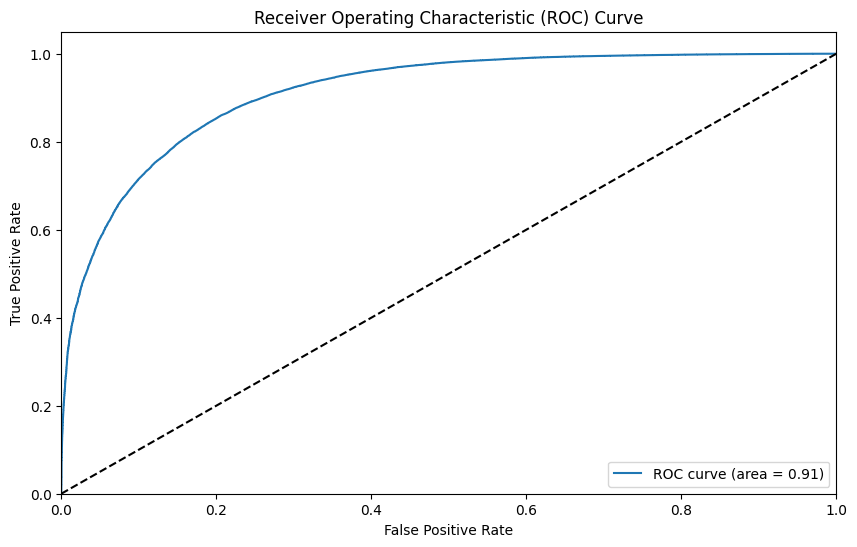

End Time: 2024-10-27 11:25:09.773069
Duration: 0:20:17.774568


In [3]:
# Record the start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Separate features and target variable
X = data.drop(columns=['disposition'])
y = data['disposition']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

 

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer to handle categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())  # Normalize the data
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical data
        ]), categorical_cols)
    ])

# Create a pipeline to preprocess and apply SVD
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=200, random_state=42))  # Adjust the number of components as needed
])

# Fit and transform the data
X_svd = pipeline.fit_transform(X)

# Split the SVD-transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_svd, y_encoded, test_size=0.2, random_state=42)

# Initialize the MLPClassifier with the best hyperparameters
mlp = MLPClassifier(
    solver='sgd',
    learning_rate='adaptive',
    hidden_layer_sizes=(50, 50),
    alpha=0.001,
    activation='tanh',
    random_state=42,
    max_iter=1000
)

# Train the model
mlp.fit(X_train, y_train)

# Print the machine learning model and hyperparameters used
print("Machine Learning Model: MLPClassifier")
print("Hyperparameters:")
print(f"  solver: {mlp.get_params()['solver']}")
print(f"  learning_rate: {mlp.get_params()['learning_rate']}")
print(f"  hidden_layer_sizes: {mlp.get_params()['hidden_layer_sizes']}")
print(f"  alpha: {mlp.get_params()['alpha']}")
print(f"  activation: {mlp.get_params()['activation']}")
print(f"  random_state: {mlp.get_params()['random_state']}")
print(f"  max_iter: {mlp.get_params()['max_iter']}")

# Predict and evaluate the model
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
interpretability_index = (accuracy + precision + recall + specificity + f1) / 5

# Print the evaluation metrics in the specified template format
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUROC: {auc}")
print(f"Sensitivity/Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"Accuracy Interpretability Index: {interpretability_index}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# # Function to calculate metrics
# def calculate_metrics(y_true, y_pred, y_proba):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred)
#     auc = roc_auc_score(y_true, y_proba)
#     conf_matrix = confusion_matrix(y_true, y_pred)
#     specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
#     return accuracy, precision, recall, f1, auc, specificity

# # Bootstrapping
# n_iterations = 1000
# metrics = np.zeros((n_iterations, 6))

# for i in range(n_iterations):
#     # Resample the data
#     X_resampled, y_resampled = resample(X_test, y_test, random_state=i)
#     y_pred_resampled = mlp.predict(X_resampled)
#     y_proba_resampled = mlp.predict_proba(X_resampled)[:, 1]
    
#     # Calculate metrics
#     metrics[i] = calculate_metrics(y_resampled, y_pred_resampled, y_proba_resampled)

# # Calculate mean and 95% confidence intervals
# mean_metrics = np.mean(metrics, axis=0)
# ci_lower = np.percentile(metrics, 2.5, axis=0)
# ci_upper = np.percentile(metrics, 97.5, axis=0)

# metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Specificity']
# for mean, lower, upper, name in zip(mean_metrics, ci_lower, ci_upper, metric_names):
#     print(f'{name}: {mean:.4f} (95% CI: {lower:.4f} - {upper:.4f})')

    
    
# Record the end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the duration
duration = end_time - start_time
print(f"Duration: {duration}")

# Train and evaluate the model with a specified number of components=300 for SVD

Start Time: 2024-10-27 11:25:09.845349


/home/faruque/anaconda3/envs/my_env/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['phencyclidine(pcp)screen,urine,noconf._last'
 'phencyclidine(pcp)screen,urine,noconf._min'
 'phencyclidine(pcp)screen,urine,noconf._max'
 'phencyclidine(pcp)screen,urine,noconf._median']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Machine Learning Model: MLPClassifier
Hyperparameters:
  solver: sgd
  learning_rate: adaptive
  hidden_layer_sizes: (50, 50)
  alpha: 0.001
  activation: tanh
  random_state: 42
  max_iter: 1000

Accuracy: 0.8524059305250763
Precision: 0.876613069345321
Confusion Matrix:
[[23207 10183]
 [ 6362 72346]]
AUROC: 0.9057169985898192
Sensitivity/Recall: 0.9191695888600905
Specificity: 0.6950284516322253
F1 Score: 0.8973870761673809
Accuracy Interpretability Index: 0.8481208233060187


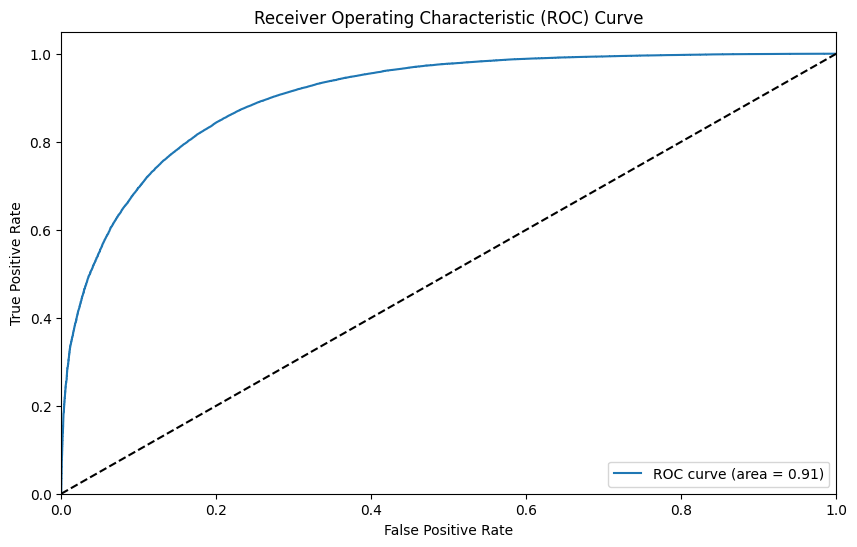

Accuracy: 0.8524 (95% CI: 0.8505 - 0.8545)
Precision: 0.8767 (95% CI: 0.8745 - 0.8791)
Recall: 0.9192 (95% CI: 0.9173 - 0.9210)
F1 Score: 0.8974 (95% CI: 0.8960 - 0.8989)
AUROC: 0.9057 (95% CI: 0.9036 - 0.9076)
Specificity: 0.6950 (95% CI: 0.6900 - 0.6997)
End Time: 2024-10-27 12:52:26.292129
Duration: 1:27:16.446780


In [4]:
# Record the start time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Separate features and target variable
X = data.drop(columns=['disposition'])
y = data['disposition']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

 

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer to handle categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())  # Normalize the data
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical data
        ]), categorical_cols)
    ])

# Create a pipeline to preprocess and apply SVD
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=300, random_state=42))  # Adjust the number of components as needed
])

# Fit and transform the data
X_svd = pipeline.fit_transform(X)

# Split the SVD-transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_svd, y_encoded, test_size=0.2, random_state=42)

# Initialize the MLPClassifier with the best hyperparameters
mlp = MLPClassifier(
    solver='sgd',
    learning_rate='adaptive',
    hidden_layer_sizes=(50, 50),
    alpha=0.001,
    activation='tanh',
    random_state=42,
    max_iter=1000
)

# Train the model
mlp.fit(X_train, y_train)

# Print the machine learning model and hyperparameters used
print("Machine Learning Model: MLPClassifier")
print("Hyperparameters:")
print(f"  solver: {mlp.get_params()['solver']}")
print(f"  learning_rate: {mlp.get_params()['learning_rate']}")
print(f"  hidden_layer_sizes: {mlp.get_params()['hidden_layer_sizes']}")
print(f"  alpha: {mlp.get_params()['alpha']}")
print(f"  activation: {mlp.get_params()['activation']}")
print(f"  random_state: {mlp.get_params()['random_state']}")
print(f"  max_iter: {mlp.get_params()['max_iter']}")

# Predict and evaluate the model
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
interpretability_index = (accuracy + precision + recall + specificity + f1) / 5

# Print the evaluation metrics in the specified template format
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUROC: {auc}")
print(f"Sensitivity/Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"Accuracy Interpretability Index: {interpretability_index}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    return accuracy, precision, recall, f1, auc, specificity

# Bootstrapping
n_iterations = 1000
metrics = np.zeros((n_iterations, 6))

for i in range(n_iterations):
    # Resample the data
    X_resampled, y_resampled = resample(X_test, y_test, random_state=i)
    y_pred_resampled = mlp.predict(X_resampled)
    y_proba_resampled = mlp.predict_proba(X_resampled)[:, 1]
    
    # Calculate metrics
    metrics[i] = calculate_metrics(y_resampled, y_pred_resampled, y_proba_resampled)

# Calculate mean and 95% confidence intervals
mean_metrics = np.mean(metrics, axis=0)
ci_lower = np.percentile(metrics, 2.5, axis=0)
ci_upper = np.percentile(metrics, 97.5, axis=0)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Specificity']
for mean, lower, upper, name in zip(mean_metrics, ci_lower, ci_upper, metric_names):
    print(f'{name}: {mean:.4f} (95% CI: {lower:.4f} - {upper:.4f})')

    
    
# Record the end time
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")

# Calculate the duration
duration = end_time - start_time
print(f"Duration: {duration}")